In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pymeasure.adapters import VXI11Adapter 
from T3AWG3252 import T3AWG3252, upload_signal_teledyne

In [5]:
M = 2                          # Number of encoding symbols
SYMBOL_BITS = 1                # Number of bits per symbol
MOD_SYMBOL_BITS = 2            # Number of bits per symbol after encoding
NUM_SYMBOLS = 10               # Packet symbols.

seed = 1234                    # Used for generated random symbols consistently.
rng = np.random.default_rng(seed) # Bit generator. Generates decimal integers.

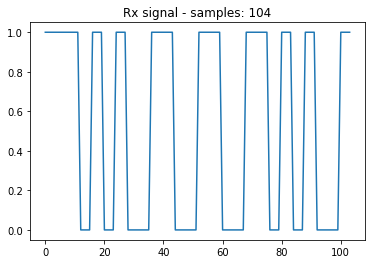

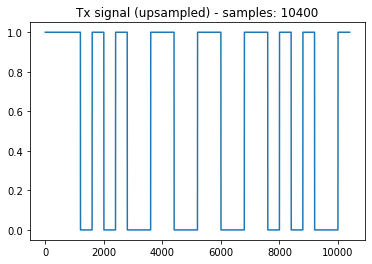

Packet frequency (Packet rate) : 508.6563131369649
Packet time : 1.97ms
Symbol time : 0.076ms
Symbol time : 0.076ms


In [7]:
symbols = rng.integers(0, M, NUM_SYMBOLS) # Generate NUM_SYMBOLS for transmission

# 0) Generate look up table
look_table = np.arange(0,M)     # The index corresponds to the original symbol and the value to the modulated symbol
look_table[0] = 1               # Encoding 01 for the 0 bit
look_table[1] = 2               # Encoding 10 for the 1 bit

# 1) Encoding Manchester
enco_symbols = look_table[symbols]
bin_symbols = np.asarray([np.binary_repr(x, width=MOD_SYMBOL_BITS) for x in enco_symbols])
bin_symbols = np.asarray([int(s) for s in list(''.join(bin_symbols))])

# 2) Framing with selected header (forbidden selected symbol or symbols not found in data)
header = np.asarray([1, 1, 1, 0, 1, 0])
bin_symbols = np.concatenate([header.flatten(), bin_symbols.flatten()])

# 3) Modulation (OOK)
RX_NUM_SAMPLES_SYMB = 4
RX_CAMERA_SAMPLING_TIME = 18.9035e-6
RX_CAMERA_SAMPLING_FREQUENCY = 1/RX_CAMERA_SAMPLING_TIME
RX_SYMBOL_TIME = RX_NUM_SAMPLES_SYMB * RX_CAMERA_SAMPLING_TIME

samples = np.repeat(bin_symbols, RX_NUM_SAMPLES_SYMB)
plt.plot(samples)
plt.title("Rx signal - samples: {}".format(len(samples)))
plt.show()
RX_NUM_SAMPLES = len(samples)
RX_SIGNAL_TIME = RX_CAMERA_SAMPLING_TIME * RX_NUM_SAMPLES

TX_UPSAMPLING_FACTOR = 100
samples = np.repeat(samples, TX_UPSAMPLING_FACTOR)
plt.plot(samples)
plt.title("Tx signal (upsampled) - samples: {}".format(len(samples)))
plt.show()
TX_NUM_SAMPLES = len(samples)
TX_FS = TX_NUM_SAMPLES / RX_SIGNAL_TIME

print("Packet frequency (Packet rate) : {}".format(1/RX_SIGNAL_TIME))
print("Packet time : {:.2f}ms".format(RX_SIGNAL_TIME*1e3))
print("Symbol time : {:.3f}ms".format(RX_SYMBOL_TIME*1e3))
print("Symbol time : {:.3f}ms".format(RX_SIGNAL_TIME*1e3 / (NUM_SYMBOLS * MOD_SYMBOL_BITS + len(header))))

In [8]:
ip_addr = '192.168.1.88'
conn_adapter = VXI11Adapter(host=ip_addr)
awg = T3AWG3252(conn_adapter)
upload_signal_teledyne(awg, name="temp1", samples=samples, amp=3, fs = TX_FS, channel=1, run=True)